# Simulations
In this Notebook, I focus on simulations that concern only the individual models. In the next notebook 05_Community I'll merge them into one big model for more sophisticated analyses.

## Imports

In [1]:
# basics
import pandas as pd
import random
import re
import os
import ast
# plot
import matplotlib.pyplot as plt
import seaborn as sns
# cobra
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible

In [2]:
# Load SBML Models
models_path = "/home/lisa/Dokumente/Programmierung/Models/10_duplicate_removal/"
models_curation = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models_curation[name] = model

models_curation = {key: models_curation[key] for key in sorted(models_curation.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models_curation[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


## Basic Functions

In [3]:
def get_rxn(model, rxn_id, bounds = False, print_mass = False, print_GPR=False, charge=True):
    rxn = model.reactions.get_by_id(rxn_id)
    charges = {met.id: met.charge for met in rxn.metabolites}
    masses = {met.id: met.formula for met in rxn.metabolites}
    gpr = rxn.gene_reaction_rule
    up = rxn.upper_bound
    lb = rxn.lower_bound
    print(rxn)

    if charge:
        print(charges)
    if print_mass:
        print(masses)
    if print_GPR:
        print(gpr)
    if bounds:
        print(f"from {lb} to {up}")

In [4]:
def get_rxn_unknown(models, rxn_id, bounds=False, print_mass = False, print_GPR=False, charge=True):
    model_list = []
    gpr_list= []
    ub = set()
    lb = set()
    for model in models.values():
        if rxn_id in model.reactions:
            model_list.append(model)
            gpr_list.append(model.reactions.get_by_id(rxn_id).gene_reaction_rule)
            lb.add(model.reactions.get_by_id(rxn_id).lower_bound)
            ub.add(model.reactions.get_by_id(rxn_id).upper_bound)

    print(f"{rxn_id} is found in: {[model.id for model in model_list]}")

    if model_list:
        get_rxn(model_list[0], rxn_id, print_mass=print_mass, charge=charge)

    if bounds:
        print(f"lower bound: {lb}; upper bound: {ub}")

    if print_GPR:
        print(f"all GPRs: {set(gpr_list)}")

In [5]:
def get_met(model, met_id):
    if met_id in model.metabolites:
        met = model.metabolites.get_by_id(met_id)
        rxns = {rxn.id:model.reactions.get_by_id(rxn.id).reaction for rxn in met.reactions}
        print(f"{met.name} ({met.formula})")
        print(rxns)
        return

    else:
        query_mets = set()
        if "_" in met_id:
            met_id = met_id.split("_")[0]

        mets = [met.id for met in model.metabolites.query(met_id)]
        query_mets.update(set(mets))

        if query_mets:
            print(f"No exact match for your ID was found, but \"{met_id}\" got the following metabolites: {query_mets}")
            return

    print("No match.")

In [6]:
def get_met_unknown(models, met_id):
    model_list = []
    rxn_list = []
    for model in models.values():
        if met_id in model.metabolites:
            model_list.append(model)
            rxns = model.metabolites.get_by_id(met_id).reactions
            for rxn in rxns:
                rxn_list.append(rxn.id)

    met_name, met_formula, met_charge = ["" for _ in range(3)]
    if model_list:
        met_name = model_list[0].metabolites.get_by_id(met_id).name
        met_formula = model_list[0].metabolites.get_by_id(met_id).formula
        met_charge = model_list[0].metabolites.get_by_id(met_id).charge
        print(f"{met_id} ({met_name} ({met_formula}, {met_charge})) is found  models: {[model.id for model in model_list]} and in reactions: {set(rxn_list)}")
        return

    if len(model_list) == 0:
        query_mets = set()
        if "_" in met_id:
            met_id = met_id.split("_")[0]
        for model in models.values():
            mets = [met.id for met in model.metabolites.query(met_id)]
            query_mets.update(set(mets))

        if query_mets:
            print(f"No exact match for your ID was found, but \"{met_id}\" got the following metabolites: {query_mets}")
            return

    print("No match.")

# Vitamin B
This is only the research to check which vitamins are available in my models.

In [27]:
Bvitamins = {
    "B1": ["thm", "thmmp", "thmpp"],
    "B2": ["ribflv"],
    "B3": ["ncam", "nicnt", "nac"],
    "B5": ["pnto__R"],
    "B6": ["pydam", "pydxn", "pydx"],
    "B7": ["btn"],
    "B9": ["fol", "5mthf"],
    "B12": ["b12", "adocbl", "C06453", "adocbi"]
}

In [28]:
def check_B_vitamins(model):
    metabos = model.metabolites

    # Convert model metabolite IDs to base names (without compartment suffixes)
    model_mets = {met.id.rsplit('_', 1)[0] for met in metabos}

    # Track which B vitamins are missing
    missing_vitamins = []

    for Bname, vit_mets in Bvitamins.items():
        if not any(vit in model_mets for vit in vit_mets):
            missing_vitamins.append(Bname)

    if missing_vitamins:
        print(model.id, "- Missing B vitamins in:", ', '.join(missing_vitamins))
    else:
        print(model.id, "- All B vitamins are present.")


In [29]:
for model in models_curation.values():
    check_B_vitamins(model)

AA1 - Missing B vitamins in: B12
AA2 - All B vitamins are present.
AA3 - All B vitamins are present.
AA4 - All B vitamins are present.
AA5 - Missing B vitamins in: B12
AA6 - All B vitamins are present.
AA7 - Missing B vitamins in: B7


# Medium


## Functions

In [7]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

In [8]:
# change medium
def change_medium(model, medium_dict):

    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)

In [9]:
# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict):
    with model:
        change_medium(model, medium_dict)
        try:
            solution = pfba(model)
            growth = solution.fluxes["Growth"]
            return growth
        except Infeasible:
            return None

In [10]:
# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()

In [11]:
# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        med_dict = {new_medium[i]: 1000.0 for i in range(len(new_medium))}

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            # print(growth_val)
            results[carbon_key][model.id] = growth_val
        #print("-----")

    visualise_heatmap_medium(results)

## get all exchange reactions

In [19]:
# GET ALL EXCHANGE REACTIONS

# Dictionary to collect info: key = reaction_id, value = dict with metabolite_id and set of models
ex_rxn_info = {}

for model_id, model in models_curation.items():
    ex_reactions = [rxn for rxn in model.reactions if rxn.id.startswith("EX_")]

    for rxn in ex_reactions:
        mets = list(rxn.metabolites.keys())
        if len(mets) == 1:
            if rxn.id not in ex_rxn_info:
                ex_rxn_info[rxn.id] = {
                    'metabolite_id': mets[0].name,
                    'model_ids': set()
                }
            ex_rxn_info[rxn.id]['model_ids'].add(model_id)
        else:
            print("dafuq")

# Convert to DataFrame, model_ids as sorted lists
df = pd.DataFrame([
    {'reaction_id': rxn_id,
     'metabolite_name': info['metabolite_id'],
     'model_id': sorted(list(info['model_ids']))}
    for rxn_id, info in ex_rxn_info.items()
])

In [ ]:
#df.to_csv("../Datasets/exchange_reactions.csv", index=False)

In [201]:
AA1.medium

{'EX_14glucan_e': 1000.0,
 'EX_2ddglcn_e': 1000.0,
 'EX_2dhglcn_e': 1000.0,
 'EX_2m35mdntha_e': 1000.0,
 'EX_35dnta_e': 1000.0,
 'EX_3mb_e': 1000.0,
 'EX_3oxoadp_e': 1000.0,
 'EX_4abut_e': 1000.0,
 'EX_4abutn_e': 1000.0,
 'EX_4hbz_e': 1000.0,
 'EX_5drib_e': 1000.0,
 'EX_6apa_e': 1000.0,
 'EX_6atha_e': 1000.0,
 'EX_LalaDgluMdapDala_e': 1000.0,
 'EX_LalaLglu_e': 1000.0,
 'EX_R_3h4atba_e': 1000.0,
 'EX_R_3hhpa_e': 1000.0,
 'EX_R_3hpba_e': 1000.0,
 'EX_R_3hpdeca_e': 1000.0,
 'EX_R_3hphpa_e': 1000.0,
 'EX_R_3hpnona_e': 1000.0,
 'EX_R_3hpocta_e': 1000.0,
 'EX_ac_e': 1000.0,
 'EX_acac_e': 1000.0,
 'EX_acald_e': 1000.0,
 'EX_acgam_e': 1000.0,
 'EX_acmana_e': 1000.0,
 'EX_actn__R_e': 1000.0,
 'EX_ade_e': 1000.0,
 'EX_adn_e': 1000.0,
 'EX_agm_e': 1000.0,
 'EX_akg_e': 1000.0,
 'EX_ala_B_e': 1000.0,
 'EX_ala_L_asp__L_e': 1000.0,
 'EX_ala_L_glu__L_e': 1000.0,
 'EX_ala_L_thr__L_e': 1000.0,
 'EX_ala__D_e': 1000.0,
 'EX_ala__L_e': 1000.0,
 'EX_ala_gln_e': 1000.0,
 'EX_ala_his_e': 1000.0,
 'EX_ala_leu_

In [158]:
for model in models_curation.values():
    for met in model.metabolites:
        if "phosphate" in met.name:
            print(model.id, met.name)
            rxns = model.metabolites.get_by_id(met.id).reactions
            for rxn in rxns:
                if rxn.id.startswith("EX_"):
                    print(met.name, "//", rxn)

AA1 3-Phospho-D-glyceroyl phosphate
AA1 1-hexadecanoyl-sn-glycerol 3-phosphate
AA1 1-hexadecanoyl-sn-glycerol 3-phosphate
AA1 1-octadec-11-enoyl-sn-glycerol 3-phosphate
AA1 2,5-Diamino-6-(ribosylamino)-4-(3H)-pyrimidinone 5'-phosphate
AA1 2 Amino 4 hydroxy 6 hydroxymethyl 7 8 dihydropteridine diphosphate C7H8N5O8P2
AA1 1-(2-Carboxyphenylamino)-1-deoxy-D-ribulose 5-phosphate
AA1 2-Dehydro-3-deoxy-D-arabino-heptonate 7-phosphate
AA1 2-Dehydro-3-deoxy-D-gluconate 6-phosphate
AA1 2-Dehydro-3-deoxy-D-galactonate 6-phosphate
AA1 2-Deoxy-D-ribose 1-phosphate
AA1 2-Methyl-4-amino-5-hydroxymethylpyrimidine diphosphate
AA1 2-C-methyl-D-erythritol 4-phosphate
AA1 2-C-methyl-D-erythritol 2,4-cyclodiphosphate
AA1 D-Glycerate 2-phosphate
AA1 C'-(3-Indolyl)-glycerol 3-phosphate
AA1 5-Methylthio-5-deoxy-D-ribose 1-phosphate
AA1 5-Methylthio-5-deoxy-D-ribulose 1-phosphate
AA1 6-hydroxymethyl-dihydropterin pyrophosphate
AA1 N-Acetyl-L-glutamyl 5-phosphate
AA1 N-Acetyl-D-glucosamine 1-phosphate
AA1 N-Ace

In [19]:
for met in AA1.metabolites.query("gly"):
    rxns = AA1.metabolites.get_by_id(met.id).reactions
    for rxn in rxns:
        if rxn.id.startswith("EX_"):
            print(rxn)

EX_alagly_e: alagly_e <=> 
EX_cgly_e: cgly_e <=> 
EX_gly_asn__L_e: gly_asn__L_e <=> 
EX_gly_asp__L_e: gly_asp__L_e <=> 
EX_gly_cys_e: gly_cys_e <=> 
EX_gly_gln_e: gly_gln_e <=> 
EX_gly_glu__L_e: gly_glu__L_e <=> 
EX_gly_leu_e: gly_leu_e <=> 
EX_gly_met_e: gly_met_e <=> 
EX_gly_phe_e: gly_phe_e <=> 
EX_gly_pro__L_e: gly_pro__L_e <=> 
EX_gly_tyr_e: gly_tyr_e <=> 
EX_glyb_e: glyb_e <=> 
EX_glyc2p_e: glyc2p_e <=> 
EX_glyc3p_e: glyc3p_e <=> 
EX_glyc_e: glyc_e <=> 
EX_glyclt_e: glyclt_e <=> 
EX_glyglygln_e: glyglygln_e <=> 
EX_lysglugly_e: lysglugly_e <=> 
EX_serglugly_e: serglugly_e <=> 


## Maize Root Exudate
For simulation with the MRE, we have to combine it with the M9 minimal medium

In [13]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre = pd.read_csv("../Datasets/Medium/medium_ARE_Naveed.csv", sep=";")
mre

,reaction,bound
0,EX_3mb_e,500
1,EX_ala__D_e,500
2,EX_ala__L_e,500
3,EX_all__D_e,500
4,EX_fru_e,500
5,EX_gal_e,500
6,EX_glcn__D_e,500
7,EX_glcn_e,500
8,EX_gly_e,500
9,EX_hdcea_e,500


## M9 minimal medium

In [14]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9

,reaction,bound
0,EX_na1_e,1000.0
1,EX_pi_e,1000.0
2,EX_nh4_e,1000.0
3,EX_cl_e,1000.0
4,EX_k_e,1000.0
5,EX_h_e,1000.0
6,EX_mg2_e,1000.0
7,EX_so4_e,1000.0
8,EX_ca2_e,1000.0
9,EX_fe3_e,1000.0


In [15]:
m9_rxn = list(m9["reaction"])

## BIOLOG EcoPlate

In [100]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')

In [101]:
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [102]:
ecoplate_rxns

['EX_peamn_e',
 'EX_ptrc_e',
 'EX_arg__L_e',
 'EX_asn__L_e',
 'EX_phe__L_e',
 'EX_ser__L_e',
 'EX_thr__L_e',
 ['EX_glyc2p_e', 'EX_glyc3p_e'],
 'EX_cellb_e',
 'EX_mnl_e',
 'EX_xyl__D_e',
 'EX_g1p_e',
 'EX_acgam_e',
 'EX_4hbz_e',
 'EX_galur_e',
 'EX_mal__D_e',
 'EX_salc_e',
 'EX_lcts_e',
 'EX_4abut_e',
 'EX_h2o_e']

For now I'll use the above metabolites (or rather their exchange reactions) as a carbon source but still provide the M9 minimal medium.

<class 'dict'>


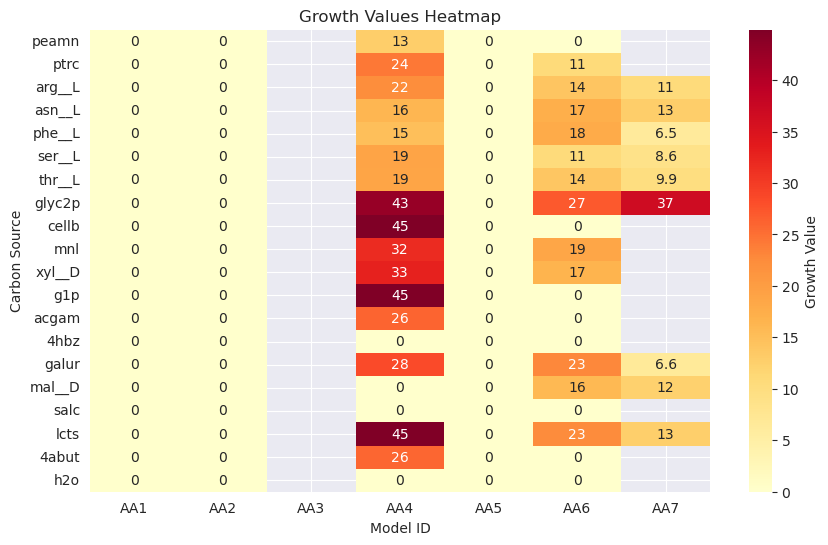

In [103]:
create_medium(ecoplate_rxns, m9_rxn, models_curation)
# create_medium(ecoplate_rxns, m9_rxn[:-1], models_curation)  # without bz

## Minimal media growth assay

Krumbach Fig. 4a shows the 9 different carbon sources they tried out for their minimal medium grwoth assay (M9 + single carbon source)
- Glucose (glc__D)
- Sucrose (sucr)
- Xylose (xyl__D)
- Malate (mal__L or maybe mal__D)
- Pyruvate (pyr)
- Succinate (succ)
- Alanine (ala__L or maybe ala__D)
- Glutamate (glu__L or glu__D)
- Glycine (gly)

In [68]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

In [49]:
m9_rxn

['EX_na1_e',
 'EX_pi_e',
 'EX_nh4_e',
 'EX_cl_e',
 'EX_k_e',
 'EX_h_e',
 'EX_mg2_e',
 'EX_so4_e',
 'EX_ca2_e',
 'EX_fe3_e',
 'EX_fe2_e',
 'EX_mn2_e',
 'EX_zn2_e',
 'EX_mobd_e',
 'EX_o2_e',
 'EX_cu2_e',
 'EX_cobalt2_e',
 'EX_bz_e']

<class 'dict'>


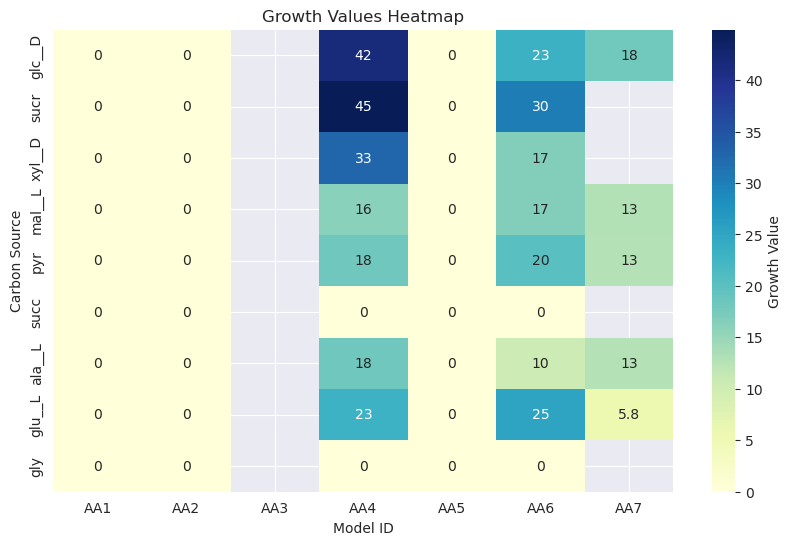

In [74]:
create_medium(carbon_sources, m9_rxn, models_curation)
# create_medium(carbon_sources, m9_rxn[:-1], models_curation)  # without bz

In [462]:
print('complete model: ', pfba(AA6).fluxes["Growth"])
with AA6:
    AA6.reactions.EX_bz_e.knock_out()
    #AA6.reactions.EX_tol_e.knock_out()
    print('bz/tol knocked out: ', pfba(AA6).fluxes["Growth"])

    print(minimal_medium(AA6, 1))

Minimization of medium was infeasible.


complete model:  67.00209821845436
bz/tol knocked out:  0.0
None


## minimal media according to cobrapy

In [316]:
max_growth = pfba(AA7).fluxes["Growth"]
minimal_medium(AA7, 3)

EX_adn_e            1.183026
EX_alatrp_e         0.170529
EX_bz_e             0.000300
EX_ca2_e            0.015615
EX_carn_e           0.001728
EX_cl_e             0.015615
EX_cobalt2_e        0.000300
EX_csn_e            0.992385
EX_cu2_e            0.002127
EX_dad_2_e          0.159549
EX_fe3_e            0.023424
EX_g3ps_e           2.892099
EX_glymet_e         0.463365
EX_gthrd_e          0.274830
EX_hishis_e         2.916479
EX_k_e              0.585579
EX_malttr_e        29.637092
EX_mg2_e            0.026025
EX_mn2_e            0.002073
EX_o2_e           500.455404
EX_pheme_e          0.000669
EX_salchs4fe_e      0.020814
EX_so4_e            0.013014
EX_tag180_e         0.364567
EX_thm_e            0.000669
EX_zn2_e            0.001023
dtype: float64

In [ ]:
# bz = 1, 2, 6, 7

# Metabolic niches

In [16]:
# combine maize root and M9
medium_mre_m9 = pd.concat([m9, mre], ignore_index=True)

In [17]:
medium_mre_m9["reaction"]

0         EX_na1_e
1          EX_pi_e
2         EX_nh4_e
3          EX_cl_e
4           EX_k_e
5           EX_h_e
6         EX_mg2_e
7         EX_so4_e
8         EX_ca2_e
9         EX_fe3_e
10        EX_fe2_e
11        EX_mn2_e
12        EX_zn2_e
13       EX_mobd_e
14         EX_o2_e
15        EX_cu2_e
16    EX_cobalt2_e
17         EX_bz_e
18        EX_3mb_e
19     EX_ala__D_e
20     EX_ala__L_e
21     EX_all__D_e
22        EX_fru_e
23        EX_gal_e
24    EX_glcn__D_e
25       EX_glcn_e
26        EX_gly_e
27      EX_hdcea_e
28     EX_ile__L_e
29      EX_inost_e
30     EX_lac__D_e
31     EX_lac__L_e
32       EX_lnlc_e
33       EX_malt_e
34     EX_ocdcea_e
35         EX_pi_e
36     EX_rib__D_e
37        EX_rmn_e
38     EX_srb__L_e
39       EX_succ_e
40       EX_urea_e
41     EX_val__D_e
42     EX_val__L_e
Name: reaction, dtype: object

In [18]:
med_wo_bz = medium_mre_m9[medium_mre_m9['reaction'] != 'EX_bz_e']

In [19]:
for model in models_curation.values():
    growth_val = test_medium(model, medium_mre_m9)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  0.0
AA4 :  41.15384084429719
AA5 :  0.0
AA6 :  33.72212836756345
AA7 :  24.999898439610895


In [181]:
for model in models_curation.values():
    growth_val = test_medium(model, med_wo_bz)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  5.517827532421014
AA4 :  39.941691196618606
AA5 :  0.0
AA6 :  0.0
AA7 :  0.0


In [183]:
AA2_requirements = list(minimal_medium(AA2, 5).index)

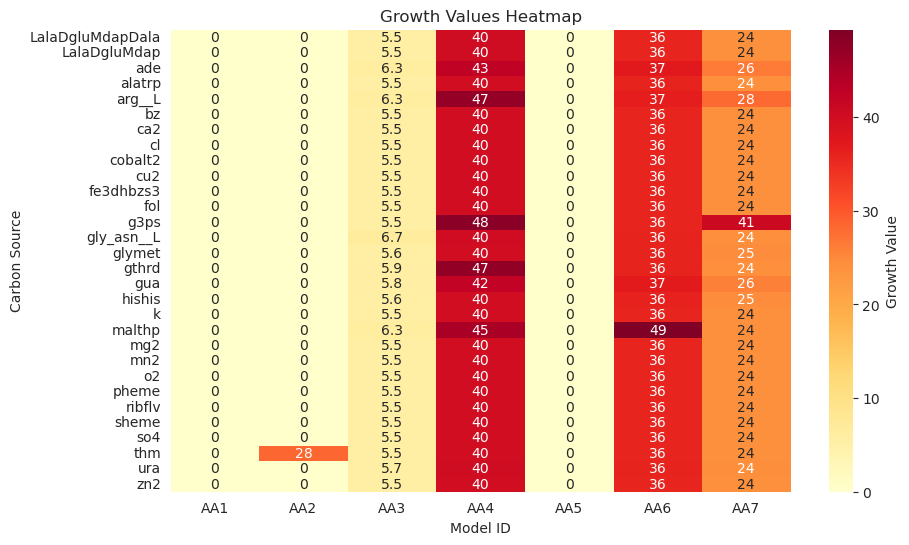

In [174]:
create_medium(AA2_requirements, list(medium_mre_m9["reaction"]), models_curation)

AA2 needs (in addition to the maize root, M9 (+ bz)) thiamin (vitamin B1) to grow. \
For AA1 and AA5 there was still no growth if we add one of their metabolites from their required minimal medium at a time. \
Some metabolites, e.g. malthp can boost growth

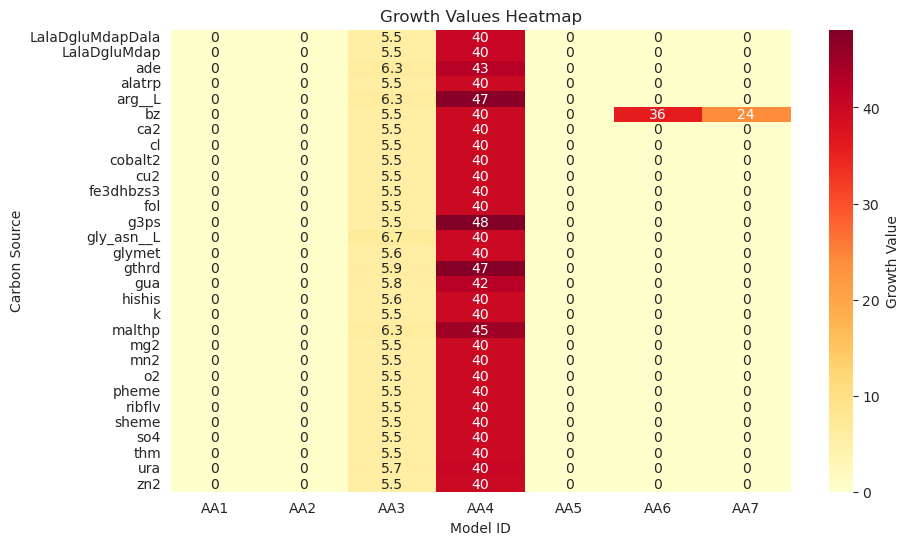

In [184]:
create_medium(AA2_requirements, list(med_wo_bz["reaction"]), models_curation)

If bz is missing then AA2 canNOT grow even if thm (thiamine) is present. As already known, AA6 and AA7 only grow with bz

# pFBA
pfba() and summary() do pFBA; optimize() does FBA
Nadine advised my to use pFBA and not normal FBA (because with the additional objective of trying to minimise the amount of fluxes, maybe it is not going to use weird cycles)

In [248]:
def uptakes_pfba(model):
    model_pfba = model.summary()
    return model_pfba.uptake_flux

In [249]:
aa2_uptake = uptakes_pfba(AA2)

In [250]:
aa2_uptake

,flux,reaction,metabolite
EX_LalaDgluMdapDala_e,1.545674,EX_LalaDgluMdapDala_e,LalaDgluMdapDala_e
EX_acald_e,1000.000000,EX_acald_e,acald_e
EX_ade_e,11.363774,EX_ade_e,ade_e
EX_akg_e,200.269532,EX_akg_e,akg_e
EX_ala_B_e,0.032039,EX_ala_B_e,ala_B_e
EX_arg__L_e,16.453072,EX_arg__L_e,arg__L_e
EX_asn__L_e,13.408393,EX_asn__L_e,asn__L_e
EX_bz_e,0.005562,EX_bz_e,bz_e
EX_ca2_e,0.289522,EX_ca2_e,ca2_e
EX_cl_e,0.289522,EX_cl_e,cl_e


In [233]:
fluxies = pfba(AA1).fluxes

In [234]:
sus_fluxies = []
for rxn, flux in fluxies.items():
    if flux > 300 or flux < -300:
        sus_fluxies.append((rxn, flux))

In [235]:
sus_EX = []
for rxn, flux in fluxies.items():
    if rxn.startswith("EX_") and flux != 0 and (flux < -1 or flux > 1):
        sus_EX.append((rxn, flux))

In [236]:
sus_EX

[('EX_adn_e', -5.875622772358431),
 ('EX_ala_L_thr__L_e', -17.947579929403524),
 ('EX_ala_his_e', -3.124917898668356),
 ('EX_arg__L_e', -9.756652189015076),
 ('EX_co2_e', 246.53159033295427),
 ('EX_cytd_e', -10.06713850052856),
 ('EX_galt_e', -476.0029836768078),
 ('EX_gam_e', -3.116671688333885),
 ('EX_gly_asn__L_e', -7.951160928703377),
 ('EX_gly_phe_e', -6.110936630462887),
 ('EX_glyc3p_e', -31.723336080915743),
 ('EX_glyglygln_e', -8.717068944569021),
 ('EX_gua_e', -7.131685530505013),
 ('EX_h2o_e', 855.2144325569088),
 ('EX_h2s_e', 6.0254564141357605),
 ('EX_h_e', 784.664153210762),
 ('EX_hxan_e', -16.47497168787375),
 ('EX_id3acald_e', -1.874957336169281),
 ('EX_k_e', -6.438410135265389),
 ('EX_lac__L_e', 800.8676596544242),
 ('EX_lys__L_e', -13.379839100933488),
 ('EX_met_L_ala__L_e', -5.079962429606017),
 ('EX_o2_e', -354.7964362781599),
 ('EX_pro__L_e', -7.291464101945718),
 ('EX_s_e', -9.069264587954255),
 ('EX_tre_e', -9.535191964272464),
 ('EX_tyr__D_e', -4.555833300747056)

In [219]:
sus_fluxies

[('EX_galt_e', -475.8912337268235),
 ('EX_h2o_e', 855.1026826069252),
 ('EX_h_e', 785.2736983924979),
 ('EX_lac__L_e', 801.5991138725079),
 ('EX_o2_e', -353.9786298259979),
 ('ATPS4rpp', 1000.0),
 ('CT6PT', 475.8912337268235),
 ('CYTBO3_4pp', 681.6683997322916),
 ('ENO', 1000.0),
 ('GALTpts', 475.8912337268235),
 ('GAPD', 1000.0),
 ('GLTPD', 475.8912337268235),
 ('H2Ot', -855.1026826069252),
 ('Htex', -800.3548956096392),
 ('LACLt2', -801.5991138725079),
 ('LDH_L', -801.5991138725079),
 ('NADH16pp', 681.6683997322916),
 ('O2tex', 353.9786298259979),
 ('O2tpp', 353.9786298259979),
 ('PGK', -1000.0),
 ('PGM', -1000.0),
 ('PYK4', 481.8059435361673),
 ('TGBPA', 475.8912337268235),
 ('TPI', 513.3978985463364)]

## get all uptakes

In [253]:
# Step 1: Collect all unique EX reactions
all_rxns = set()

# Also store each model's uptake flux dict
uptake_flux_dicts = []

for model in models_curation.values():
    uptake_fluxes = {
        rxn: flux
        for rxn, flux in pfba(model).fluxes.items()
        if rxn.startswith("EX_") and flux < 0
    }
    all_rxns.update(uptake_fluxes.keys())
    uptake_flux_dicts.append(uptake_fluxes)

# Step 2: Create empty DataFrame with full reaction list as index
df_uptake_fluxes = pd.DataFrame(index=sorted(all_rxns))  # sorted optional

# Step 3: Fill in each model's uptake data
for i, uptake_fluxes in enumerate(uptake_flux_dicts, start=1):
    df_uptake_fluxes[f'AA{i}'] = pd.Series(uptake_fluxes)


## get minimal medium that leads to certain growth

In [257]:
#max_growth = model.slim_optimize()
mini = minimal_medium(AA7, 1)
mini

EX_adn_e            0.394342
EX_alatrp_e         0.056843
EX_bz_e             0.000100
EX_ca2_e            0.005205
EX_carn_e           0.000576
EX_cl_e             0.005205
EX_cobalt2_e        0.000100
EX_csn_e            0.330795
EX_cu2_e            0.000709
EX_dad_2_e          0.053183
EX_fe3_e            0.007808
EX_g3ps_e           0.964033
EX_glymet_e         0.154455
EX_gthrd_e          0.091610
EX_hishis_e         0.972160
EX_k_e              0.195193
EX_malttr_e        28.397549
EX_mg2_e            0.008675
EX_mn2_e            0.000691
EX_o2_e           500.151801
EX_pheme_e          0.000223
EX_salchs4fe_e      0.006938
EX_so4_e            0.004338
EX_tag180_e         0.121522
EX_thm_e            0.000223
EX_zn2_e            0.000341
dtype: float64

In [259]:
get_met(AA7, "glyc3p_e")

Glycerol 3-phosphate (C3H7O6P)
{'GPDDA1_1': 'g3pc_e + h2o_e --> chol_e + glyc3p_e + h_e', 'GLYC3Pt6': 'glyc3p_e + pi_c --> glyc3p_c + pi_e', 'GPDDA2_1': 'g3pg_e + h2o_e --> glyc3p_e + glyc_e + h_e', 'GPDDA3_1': 'g3ps_e + h2o_e --> glyc3p_e + h_e + ser__L_e', 'EX_glyc3p_e': 'glyc3p_e <=> '}


In [260]:
get_met(AA7, "g3p_c")

Glyceraldehyde 3-phosphate (C3H5O6P)
{'EDA': '2ddg6p_c --> g3p_c + pyr_c', 'DRPA': '2dr5p_c --> acald_c + g3p_c', 'TRPS3': '3ig3p_c --> g3p_c + indole_c', 'TKT2': 'e4p_c + xu5p__D_c <=> f6p_c + g3p_c', 'TKT1': 'r5p_c + xu5p__D_c <=> g3p_c + s7p_c', 'FBA': 'fdp_c <=> dhap_c + g3p_c', 'DXPS': 'g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c', 'PYDXS': 'g3p_c + gln__L_c + ru5p__D_c <=> glu__L_c + 3.0 h2o_c + h_c + pi_c + pydx5p_c', 'TALA': 'g3p_c + s7p_c <=> e4p_c + f6p_c', 'TPI': 'dhap_c <=> g3p_c', 'GAPDi_nadp': '13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c', 'GAPP': 'g3p_c + h2o_c --> glyald_c + pi_c', 'GAPD': 'g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c'}


In [151]:
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = 'cplex'

In [169]:
ecoli_uptakes = {}
for rxn in ecoli.reactions:
    if rxn.id.startswith("EX_"):
        #react = ecoli.reactions.get_by_id(rxn)
        if rxn.bounds[0] < 0:
            ecoli_uptakes[rxn.id] = rxn.bounds[0]

In [170]:
ecoli_uptakes

{'EX_pi_e': -1000.0,
 'EX_co2_e': -1000.0,
 'EX_fe3_e': -1000.0,
 'EX_h_e': -1000.0,
 'EX_mn2_e': -1000.0,
 'EX_fe2_e': -1000.0,
 'EX_glc__D_e': -10.0,
 'EX_zn2_e': -1000.0,
 'EX_mg2_e': -1000.0,
 'EX_ca2_e': -1000.0,
 'EX_ni2_e': -1000.0,
 'EX_cu2_e': -1000.0,
 'EX_sel_e': -1000.0,
 'EX_cobalt2_e': -1000.0,
 'EX_h2o_e': -1000.0,
 'EX_mobd_e': -1000.0,
 'EX_so4_e': -1000.0,
 'EX_nh4_e': -1000.0,
 'EX_k_e': -1000.0,
 'EX_na1_e': -1000.0,
 'EX_cl_e': -1000.0,
 'EX_o2_e': -1000.0,
 'EX_tungs_e': -1000.0,
 'EX_slnt_e': -1000.0}

In [174]:
with AA1:
    for rxn in AA1.reactions:
        if rxn.id.startswith("EX_"):
            if rxn.id in ecoli_uptakes.keys():
                rxn.lower_bound = ecoli_uptakes[rxn.id]
            else:
                rxn.lower_bound = 0
    print(AA1.summary())

Objective
1.0 Growth = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []



##

# FVA

In [23]:
fva1 = flux_variability_analysis(AA1)

In [24]:
# reactions that do not have a flux
for rxn in fva1.iterrows():
    # first[]: [0] gets index aka rxn name and [1] accesses the data; second []: [0] minimum and [1] maximum
    if rxn[1][0] == 0 and rxn[1][1] == 0:
        print(rxn[0])

EX_6apa_e
EX_R_3hpba_e
EX_apc_e
EX_arab__L_e
EX_cd2_e
EX_ch4s_e
EX_cm_e
EX_cro4_e
EX_dca_e
EX_ddca_e
EX_doxrbcn_e
EX_enter_e
EX_feenter_e
EX_for_e
EX_fusa_e
EX_glcur_e
EX_gly_asp__L_e
EX_gly_leu_e
EX_gly_pro__L_e
EX_gly_tyr_e
EX_h2_e
EX_hxa_e
EX_ile__L_e
EX_inost_e
EX_isetac_e
EX_m_xyl_e
EX_mal__D_e
EX_na1_e
EX_ni2_e
EX_nona_e
EX_novbcn_e
EX_octa_e
EX_oxa_e
EX_p_xyl_e
EX_phedca_e
EX_phehpa_e
EX_phenona_e
EX_pheocta_e
EX_pta_e
EX_ptrc_e
EX_quin_e
EX_salchs4fe_e
EX_serglugly_e
EX_ttrcyc_e
2AGPE160tipp
2AGPG160tipp
2AGPG181tipp
3MBtex
4ABUTabcpp
6APAt1
AACPS5
AALDH
ACCOAC
ACGAMK
ACGK_1
ACGS
ACPPAT181
ACPS1
ACPpds
ADSL1r
ADSL2r
ADSS
AGPAT181
AHGDx
AICART
ALAALAD_1
ALDD31
AM3PA
AMPEP18
ANS
APTNAT
ASPK
ATPPRT
BGLA
BPNT2
BZDH
CINNMCOAH
CINNMtex
CINNMtpp
DAGK160
DHBD
DHBS
DHDPRx_r
DHQS
DHQTi
DKMPPD3
DLEUabcpp
DLEUtex
ECOAH15
ENTCS
FAS120
FEENTERR4
FEENTERabcpp
FEENTERtex
FEENTERtonex
FEENTERtpp
FORtex
G3PAT181
G3PEabcpp
G3PGabcpp
GALM1
GALUi
GCVHADPr
GCVHRADPr
GGDAPAH
GGDAPDxr
GGDAPO
GGDAPS
GG

In [25]:
get_rxn_unknown(models_curation, "NTP1", bounds=True)

NTP1 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
NTP1: atp_c + h2o_c --> adp_c + h_c + pi_c
{'atp_c': -4, 'h2o_c': 0, 'adp_c': -3, 'h_c': 1, 'pi_c': -2}
lower bound: {0.0}; upper bound: {1000.0}


In [26]:
get_rxn_unknown(models_curation, "ATPM", bounds=True)

ATPM is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
{'atp_c': -4, 'h2o_c': 0, 'adp_c': -3, 'h_c': 1, 'pi_c': -2}
lower bound: {0.0}; upper bound: {1000.0}


# Budget Plots

## Functions

In [368]:
def fba_and_query(model, met_query):
    fluxes = pfba(model)
    solution_frame=fluxes.to_frame()

    budget_mets = []
    for met in model.metabolites.query(met_query):
        budget_mets.append(met)

    print(budget_mets)
    return budget_mets, solution_frame

In [369]:
#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

In [370]:
def calc_producer_consumer(model, budget_mets, solution_frame):
    #Defining list of reactions producing and consuming the metabolite
    consumers = []
    producers = []

    #Add reactions to respective list and exclude transport reactions
    for met in budget_mets:
        for reaction in model.reactions:
            if met in reaction.reactants:
                consumers.append(reaction.id)
            elif met in reaction.products:
                producers.append(reaction.id)

    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)

    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[producers_df["fluxes"] != 0]

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux
    consumers_df = consumers_df[consumers_df["fluxes"] != 0]

    #Sum the flux values
    print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
    print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]
    all_reactions = pd.concat(frame)
    all_reactions["label"] = all_reactions.index

    return all_reactions


In [371]:
def make_budget_plot(all_reactions, save = False):
    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]


    """
    Plot the pivot table and barplot
    """
    mets = [met.id for met in budget_mets]

    chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    plt.title(f"Budget Plot for {mets}" )
    figsize = [11, 14] #To prevent the cropping of the image

    if save == True:
        plt.savefig('Budget_plot.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image

    return chart.T

## Query

In [ ]:
#old_AA6_med = AA6.medium

In [789]:
AA6.medium = old_AA6_med

In [677]:
#old_AA4_med = AA4.medium

In [732]:
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = 'cplex'

In [796]:
pseudi = read_sbml_model("../Models/iJN1463.xml")
pseudi.solver = 'cplex'

In [737]:
new_medium = m9_rxn[:-1] + ["EX_glc__D_e"] + ["EX_ni2_e"]
ecoli.medium = {new_medium[i]: 1000.0 for i in range(len(new_medium))}

In [806]:
pseudi.reactions.BIOMASS_KT2440_WT3.metabolites

{<Metabolite 10fthf_c at 0x7055e6d3eb30>: -0.000223,
 <Metabolite 2fe2s_c at 0x7055e6d3f970>: -0.000223,
 <Metabolite 4fe4s_c at 0x7055e6d3fd00>: -0.000223,
 <Metabolite 5mthf_c at 0x7055e6d7f8e0>: -0.000223,
 <Metabolite accoa_c at 0x7055e6d7efb0>: -0.000279,
 <Metabolite adocbl_c at 0x7055e6d7f670>: -0.000223,
 <Metabolite ala__L_c at 0x7055e6d7e650>: -0.598267,
 <Metabolite amet_c at 0x7055e6d5ec80>: -0.000223,
 <Metabolite arg__L_c at 0x7055e6d5fbe0>: -0.354251,
 <Metabolite asn__L_c at 0x7055e6d5efe0>: -0.158931,
 <Metabolite asp__L_c at 0x7055e6d5dea0>: -0.284685,
 <Metabolite atp_c at 0x7055e6d7f8b0>: -46.918883,
 <Metabolite bmocogdp_c at 0x7055e6d5f8b0>: -0.000223,
 <Metabolite btamp_c at 0x7055e6d5caf0>: -0.000223,
 <Metabolite ca2_c at 0x7055e6d5f4f0>: -0.004226,
 <Metabolite chor_c at 0x7055e6d5c400>: -0.000223,
 <Metabolite cl_c at 0x7055e6d5e560>: -0.004226,
 <Metabolite clpn140_p at 0x7055e6d5e590>: -1.8e-05,
 <Metabolite clpn160_p at 0x7055e6d5ca30>: -0.000578,
 <Metabo

In [797]:
budget_mets, solution_frame = fba_and_query(pseudi, "^mql8_c")

[]


In [419]:
solution_frame

,fluxes,reduced_costs
EX_14glucan_e,0.000000,2.0
EX_2ddglcn_e,0.000000,2.0
EX_2dhglcn_e,-0.000000,-2.0
EX_2m35mdntha_e,-0.000000,-2.0
EX_35dnta_e,-0.000000,-2.0
...,...,...
sink_2ohph_c,-0.000000,-2.0
sink_hemeO_c,-0.000000,-2.0
sink_mobd_c,-0.000000,-2.0
Growth,32.984841,-2.0


## Create Plot

In [794]:
all_reactions = calc_producer_consumer(AA6, budget_mets, solution_frame)

Sum of consumer fluxes: 329.0526613713827
Sum of producer fluxes: 262.05726336275023


Status,Consumer,Producer
label,,
AMMQT8,NaN,0.006700
Growth,67.002098,NaN
NADH17pp,NaN,262.050563
NO3R2,262.050563,NaN


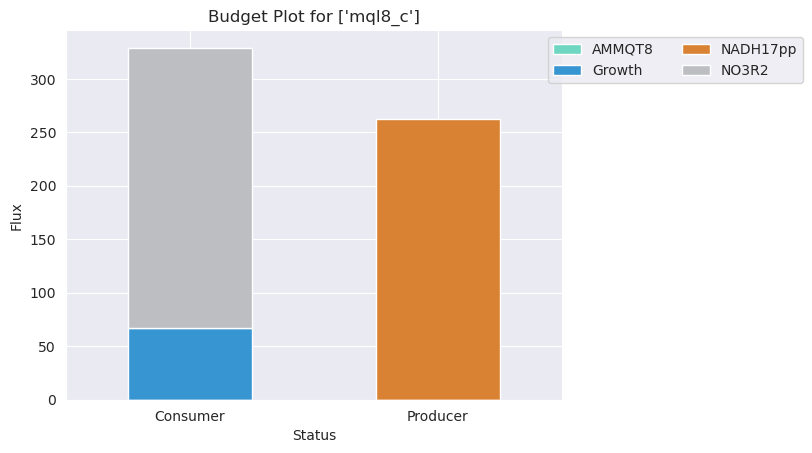

In [795]:
budget_plot = make_budget_plot(all_reactions)
budget_plot

In [786]:
get_rxn(AA7, "AMMQT8_2")

AMMQT8_2: 2dmmq8_c + amet_c --> ahcys_c + h_c + mqn8_c
{'2dmmq8_c': 0, 'amet_c': 1, 'ahcys_c': 0, 'h_c': 1, 'mqn8_c': 0}


In [777]:
get_met_unknown(models_curation, "2dmmql8_c")

2dmmql8_c (2-Demethylmenaquinol 8 (C50H72O2, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6'] and in reactions: {'GLYCTO4', 'TMAOR2pp', 'NADH9', 'DMSOR2pp', 'DHNAOT4', 'NADPHQR4', 'AMMQLT8', 'FRD3', 'NADH18pp', 'G3PD7'}


In [778]:
get_met(AA7, "mql8_c")

Menaquinol 8 (C51H74O2)
{'QMO3': 'mql8_c + 2.0 o2_c --> 2.0 h_c + mqn8_c + 2.0 o2s_c', 'CYTBD2pp': '2.0 h_c + mql8_c + 0.5 o2_c --> h2o_c + 2.0 h_p + mqn8_c', 'GLYCTO3': 'glyclt_c + mqn8_c --> glx_c + mql8_c', 'NADH10': 'h_c + mqn8_c + nadh_c --> mql8_c + nad_c', 'PCMEH3pp': '4hba_p + mqn8_c --> 4hbald_p + mql8_c', 'NADPHQR3': 'h_c + mqn8_c + nadph_c --> mql8_c + nadp_c', 'FADMQOR': 'fadh2_c + mqn8_c --> fad_c + mql8_c', 'Growth': '0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_p + 0.450531 leu__

In [773]:
get_rxn_unknown(models_curation, "AMMQT8")

AMMQT8 is found in: ['AA1', 'AA2', 'AA6']
AMMQT8: 2dmmq8_c + amet_c + h_c --> ahcys_c + mql8_c
{'2dmmq8_c': 0, 'amet_c': 1, 'h_c': 1, 'ahcys_c': 0, 'mql8_c': 0}


In [774]:
get_rxn_unknown(models_curation, "AMMQT8_2")

AMMQT8_2 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6', 'AA7']
AMMQT8_2: 2dmmq8_c + amet_c --> ahcys_c + h_c + mqn8_c
{'2dmmq8_c': 0, 'amet_c': 1, 'ahcys_c': 0, 'h_c': 1, 'mqn8_c': 0}


In [776]:
get_met(AA7, "amet_c")

S-Adenosyl-L-methionine (C15H23N6O5S)
{'AMMQT8_2': '2dmmq8_c + amet_c --> ahcys_c + h_c + mqn8_c', 'HCYSMT': 'amet_c + hcys__L_c --> ahcys_c + h_c + met__L_c', 'Growth': '0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_p + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 0.0001 mql8_c + 0.013894 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.017868 pe160_c + 0.045946 pe160_p + 0.054154 pe161_c + 0.02106 pe161_p + 0.185265 phe__L

In [684]:
get_met(AA4, "mql8_c")

Menaquinol 8 (C51H74O2)
{'FDH5pp': 'for_p + 2.0 h_c + mqn8_c --> co2_p + h_p + mql8_c', 'NO3R2pp': '2.0 h_c + mql8_c + no3_c --> h2o_c + 2.0 h_p + mqn8_c + no2_c', 'DHORD5': 'dhor__S_c + mqn8_c --> mql8_c + orot_c', 'ASPO4': 'asp__L_c + mqn8_c --> h_c + iasp_c + mql8_c', 'FDH5pp_1': 'for_p + 2.0 h_c + mqn8_c --> co2_c + h_p + mql8_c', 'TETDHpp1': 'mql8_c + tet_p --> 2.0 h_p + mqn8_c + 2.0 tsul_p', 'NADH17pp': '4.0 h_c + mqn8_c + nadh_c --> 3.0 h_p + mql8_c + nad_c', 'HYD2': 'h2_c + 2.0 h_c + mqn8_c --> 2.0 h_e + mql8_c', 'MDH3': 'mal__L_c + mqn8_c --> mql8_c + oaa_c', 'NADPHQR3': 'h_c + mqn8_c + nadph_c --> mql8_c + nadp_c', 'L_LACD3': 'lac__L_c + mqn8_c --> mql8_c + pyr_c', 'GLYCTO3': 'glyclt_c + mqn8_c --> glx_c + mql8_c', 'SELR': 'mql8_c + sel_c --> h2o_c + mqn8_c + slnt_c', 'NO3R2': '2.0 h_c + mql8_c + no3_c --> h2o_c + 2.0 h_e + mqn8_c + no2_c', 'FRD2': 'fum_c + mql8_c --> mqn8_c + succ_c', 'QMO3': 'mql8_c + 2.0 o2_c --> 2.0 h_c + mqn8_c + 2.0 o2s_c', 'CYTBD2pp': '2.0 h_c + mql8_c

In [428]:
get_rxn_unknown(models_curation, "AMMQT8")

AMMQT8 is found in: ['AA1', 'AA2', 'AA6']
AMMQT8: 2dmmq8_c + amet_c + h_c --> ahcys_c + mql8_c
{'2dmmq8_c': 0, 'amet_c': 1, 'h_c': 1, 'ahcys_c': 0, 'mql8_c': 0}


In [433]:
get_met_unknown(models_curation, "2dmmq8_c")

2dmmq8_c (2-Demethylmenaquinone 8 (C50H70O2, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'GLYCTO4', 'TMAOR2pp', 'NADH9', 'DHNAOT', 'DMSOR2pp', 'AMMQT8', 'DHNAOT_1', 'AMMQT8_2', 'NADH18pp', 'FRD3', 'NADPHQR4', 'G3PD7'}


# Spielplatz